In [56]:
!wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
import colab_github
colab_github.github_auth(persistent_key=True)

Mounted at /content/drive/
Please go to https://github.com/settings/ssh/new to upload the following key: 
ssh-ed25519 AAAAC3NzaC1lZDI1NTE5AAAAIG2l3THWhSObXGJniq4bHr9m1Z76ZYMkTGqK3mSIj187 root@50b1b358f982

Please use SSH method to clone repo.


In [58]:
!git clone git@github.com:Madhusti-D/Hardware_Security.git

Cloning into 'Hardware_Security'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 682.45 KiB | 9.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
!pip install adversarial-robustness-toolbox[all]
!pip install tqdm
!pip install torchinfo
import json
import torchinfo
from torchinfo import summary
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')


In [ ]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15

IMG_SIZE = 32
N_CLASSES = 10

In [ ]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

input_size = (64, 1, 28, 28)

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5,self).__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
      #Pass input through feature extraction layers
      features = self.feature(x)

      #Pass the extracted features through the classifier
      output = self.classifier(features)
      return output

model = LeNet5()
summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [64, 10]                  --
├─Sequential: 1-1                        [64, 16, 5, 5]            --
│    └─Conv2d: 2-1                       [64, 6, 28, 28]           156
│    └─Tanh: 2-2                         [64, 6, 28, 28]           --
│    └─AvgPool2d: 2-3                    [64, 6, 14, 14]           --
│    └─Conv2d: 2-4                       [64, 16, 10, 10]          2,416
│    └─Tanh: 2-5                         [64, 16, 10, 10]          --
│    └─AvgPool2d: 2-6                    [64, 16, 5, 5]            --
├─Sequential: 1-2                        [64, 10]                  --
│    └─Flatten: 2-7                      [64, 400]                 --
│    └─Linear: 2-8                       [64, 120]                 48,120
│    └─Tanh: 2-9                         [64, 120]                 --
│    └─Linear: 2-10                      [64, 84]                  10,164
│  

In [ ]:
# Step 2a: Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    optimizer=optimizer,
    clip_values = (min_pixel_value, max_pixel_value),
    input_shape=(1, 28, 28),
    nb_classes=10,
    )

# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)



In [ ]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy_org = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy_org * 100))

# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv= attack.generate(x=x_test)
# Step 7: Evaluate the ART classifier on adversarial test examples
predictions_adv = classifier.predict(x_test_adv)
accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

Accuracy on benign test examples: 96.24000000000001%
Accuracy on adversarial test examples: 46.93%


In [ ]:
TEST_CLASS_LABELS = [np.argmax(label) for label in y_test]
TEST_CLASS_LABELS_ADV = [np.argmax(label) for label in predictions_adv]

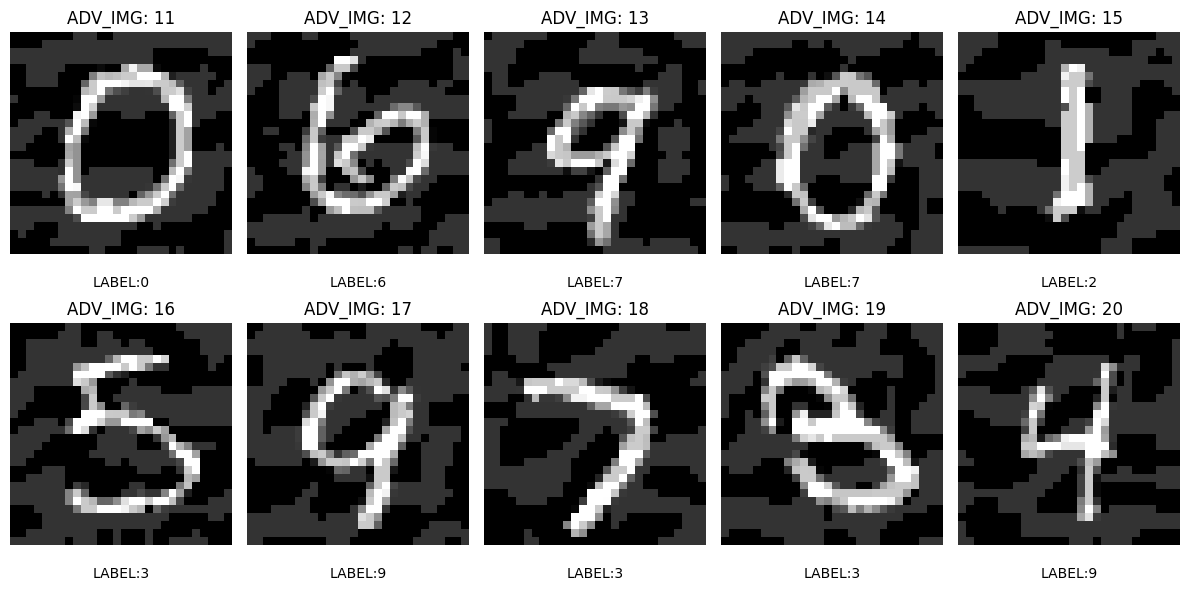

In [ ]:
# To Visualize the generated adversarial examples

#Since the test dataset has 10000 images
No_of_imgs = x_test_adv

fig,axes = plt.subplots(2,5,figsize=(12,6))

for i in range(10,20):
  adv_img = x_test_adv[i,0]
  #plt.subplot(2, 5, i+1) #Comment this line if you use range of two numbers in the for loop
  row = (i-10) // 5 #Remove -10 for if for loop range is just (10)
  col = (i-10) % 5 #Remove -10 for if for loop range is just (10) and similarly
  #subtract the first number from i in the range of the for loop as in shown in this case

  ax = axes[row,col]
  ax.imshow(adv_img)

  ax = axes[row, col]
  ax.imshow(adv_img, cmap='gray')
  ax.set_title(f"ADV_IMG: {i+1}")
  ax.axis('off')

  #Print the label below the image
  ax.text(0.5, -0.15, f"LABEL:{TEST_CLASS_LABELS_ADV[i]}", transform=ax.transAxes, ha='center')

plt.tight_layout()

plt.show()

## Iterating through Epsilon

In [ ]:
EPS = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

NO_EPS_VAL = len(EPS)
attack_for_plot = np.zeros((len(EPS), len(x_test),1,28,28))
attack_for_plot.shape

for j in range(len(EPS)):
  #Create an instance of the FastGradientMethod attack with the classifier and epsilon
  attack = FastGradientMethod(estimator=classifier, eps=EPS[j])

  #Generating adversarial examples for the current epsilion
  x_test_adv = attack.generate(x=x_test)

  #Storing the generated adversarial examples in the 5D array
  attack_for_plot[j] = x_test_adv


In [ ]:
TEST_CLASS_LABELS_ADV_NEW = [np.argmax(label) for label in predictions_adv]

Accuracy on adversarial test examples (epsilon=0.0): 96.24000000000001%
Accuracy on adversarial test examples (epsilon=0.05): 86.00999999999999%
Accuracy on adversarial test examples (epsilon=0.1): 71.83%
Accuracy on adversarial test examples (epsilon=0.15): 57.66%
Accuracy on adversarial test examples (epsilon=0.2): 46.93%
Accuracy on adversarial test examples (epsilon=0.25): 37.580000000000005%
Accuracy on adversarial test examples (epsilon=0.3): 31.019999999999996%
Accuracy on adversarial test examples (epsilon=0.35): 26.02%
Accuracy on adversarial test examples (epsilon=0.4): 21.65%
Accuracy on adversarial test examples (epsilon=0.45): 18.26%
Accuracy on adversarial test examples (epsilon=0.5): 15.06%


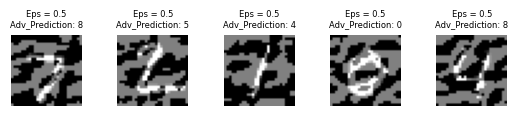

In [ ]:

# Create an empty list to store the accuracy for each epsilon value
accuracies = []
composite_images=[]
# Loop through the epsilon values
for epsilon in EPS:
    # Generate adversarial test examples for the current epsilon
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    x_test_adv = attack.generate(x=x_test)

    # Evaluate the ART classifier on adversarial test examples
    predictions_adv = classifier.predict(x_test_adv)
    accuracy_adv = np.sum(np.argmax(predictions_adv, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    accuracies.append(accuracy_adv)

    #Creating composite imgae for the current epsilon value
    composite_img=[]

    # Show the generated adversarial examples for the current epsilon
    for i in range(5):  # Show the first 5 examples
        plt.subplot(1, 5, i + 1)
        plt.imshow(x_test_adv[i][0], cmap='gray')
        plt.title(f'Eps = {epsilon}\nAdv_Prediction: {np.argmax(predictions_adv[i])}', fontsize=6)
        plt.axis('off')

    # Save the composite image for the current epsilon as a PNG file
    plt.subplots_adjust(wspace=0.5)
    file_name = f'FGSM_ADV_IMG_FOR_EPS{epsilon}.png'
    plt.savefig(file_name)
    composite_images.append(file_name)




Accuracy_Adv = []

# Print the accuracies for each epsilon value
for i, epsilon in enumerate(EPS):
    print("Accuracy on adversarial test examples (epsilon={}): {}%".format(epsilon, accuracies[i] * 100))
    Accuracy_Adv_test = accuracies[i]*100
    Accuracy_Adv.append(Accuracy_Adv_test)

In [ ]:
print (Accuracy_Adv)

[96.24000000000001, 86.00999999999999, 71.83, 57.66, 46.93, 37.580000000000005, 31.019999999999996, 26.02, 21.65, 18.26, 15.06]


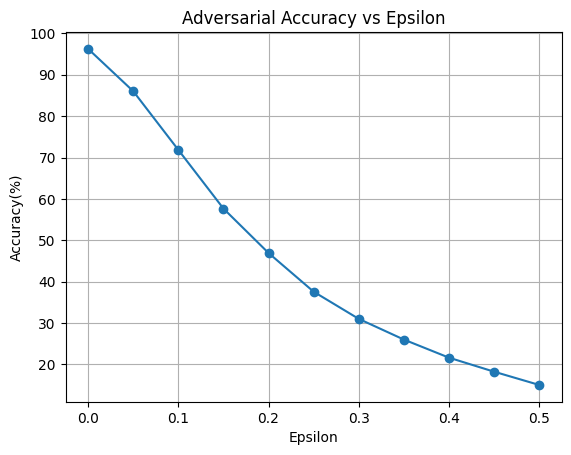

In [ ]:
#Plot of the Adversarial Accuracy against Epsilon

plt.plot(EPS, Accuracy_Adv, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy(%)')
plt.title('Adversarial Accuracy vs Epsilon in FGSM Attack')
plt.grid(True)

#Saving the plot as an image file
plt.savefig('accuracy_vs_epsilon_FGSM.png')

#Shwoing the plot
plt.show()
